# Project 2: Movie Data Analytics
by Matthew Gulbin, David Jimenez, and Shefat Moral
___

## Scenario

Our company wants to expand into movie production, and we are tasked with analyzing the trends of the market to determine what type of movie will be the most successful. We will look at what genres are the most successful, and which directors would result in the biggest return on investment and the most critical acclaim. For the purpose of this study, we will assume that we have a budget of **20 million dollars** with which to make movies.

## Intro

First, let's import all of our neccessary packages and read our data from the files.

In [46]:
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [26]:
bom_movie_df = pd.read_csv('./zippedData/bom.movie_gross.csv')
rt_movie_df = pd.read_csv('./zippedData/rt.movie_info.tsv', delimiter="\t")
rt_reviews_df = pd.read_csv('./zippedData/rt.reviews.tsv', delimiter="\t", encoding="latin1")
tmdb_movie_df = pd.read_csv('./zippedData/tmdb.movies.csv')
tn_movie_df = pd.read_csv('./zippedData/tn.movie_budgets.csv')
conn = sqlite3.connect('./zippedData/im.db')

In [27]:
bom_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [28]:
rt_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [29]:
rt_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [30]:
tmdb_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [31]:
tn_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### SQL Database Structure
![erd](./images/movie_data_erd.jpeg)

## Analysis 1: Genre

In [55]:
tmdb_df = pd.read_csv('zippedData/tmdb.movies.csv')
budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv')
bom_df = pd.read_csv('zippedData/bom.movie_gross.csv')

In [56]:
# Remove dollar signs & commas, then convert to int
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    budgets_df[col] = budgets_df[col].replace('[\$,]', '', regex=True).astype(float).fillna(0).astype(int)

print("✅ Converted budget & revenue columns to integers!")

✅ Converted budget & revenue columns to integers!


In [57]:
# Remove commas and convert to numeric, replace NaNs with 0
bom_df['foreign_gross'] = bom_df['foreign_gross'].replace(',', '', regex=True).astype(float).fillna(0)

print("✅ Converted foreign_gross to a numeric type!")

✅ Converted foreign_gross to a numeric type!


In [58]:
# Convert release_date to datetime format
tmdb_df['release_date'] = pd.to_datetime(tmdb_df['release_date'], errors='coerce')
budgets_df['release_date'] = pd.to_datetime(budgets_df['release_date'], errors='coerce')

print("✅ Converted release_date to datetime format!")

✅ Converted release_date to datetime format!


In [59]:
# Rename 'movie' in budgets_df to 'title' to match tmdb_df and bom_df
budgets_df.rename(columns={'movie': 'title'}, inplace=True)

print("✅ Renamed 'movie' to 'title' in budgets_df!")

✅ Renamed 'movie' to 'title' in budgets_df!


In [60]:
# Merge budget data into tmdb_df using 'id'
movies_budget_df = tmdb_df.merge(budgets_df, on='id', how='left')

print(f"✅ Merged TMDB and Budget data! New shape: {movies_budget_df.shape}")

✅ Merged TMDB and Budget data! New shape: (26855, 15)


In [61]:
# Keep only one release_date and title column
movies_budget_df.rename(columns={'release_date_x': 'release_date', 'title_x': 'title'}, inplace=True)

# Drop the extra columns
movies_budget_df.drop(columns=['release_date_y', 'title_y'], inplace=True, errors='ignore')

print("✅ Cleaned up duplicate columns!")

✅ Cleaned up duplicate columns!


In [62]:
movies_budget_df['year'] = movies_budget_df['release_date'].dt.year

print("✅ Extracted year from release_date!")

✅ Extracted year from release_date!


In [63]:
# Merge BOM data into movies_budget_df
final_movies_df = movies_budget_df.merge(bom_df, on=['title', 'year'], how='left')

print(f"✅ Final dataset shape after merging BOM data: {final_movies_df.shape}")

✅ Final dataset shape after merging BOM data: (26855, 17)


In [64]:
matched_budgets = movies_budget_df['production_budget'].notna().sum()
total_movies = len(movies_budget_df)

print(f"✅ Movies with matched budget data: {matched_budgets} / {total_movies}")

✅ Movies with matched budget data: 344 / 26855


In [65]:
# Rename 'movie' to 'title' in budgets_df
budgets_df.rename(columns={'movie': 'title'}, inplace=True)

# Extract release year from release_date
budgets_df['year'] = budgets_df['release_date'].dt.year

print("✅ Updated budgets_df for title-based merging!")

✅ Updated budgets_df for title-based merging!


In [66]:
# Extract year from release_date in tmdb_df
tmdb_df['year'] = pd.to_datetime(tmdb_df['release_date'], errors='coerce').dt.year

print("✅ Extracted year from release_date in tmdb_df!")

✅ Extracted year from release_date in tmdb_df!


In [67]:
# Now merge using title and year
movies_budget_df = tmdb_df.merge(budgets_df, on=['title', 'year'], how='left')

print(f"✅ New merge complete! Movies with budget data: {movies_budget_df['production_budget'].notna().sum()} / {len(movies_budget_df)}")

✅ New merge complete! Movies with budget data: 1758 / 26517


In [68]:
missing_budgets = movies_budget_df['production_budget'].isna().sum()
print(f"🔍 Movies still missing budget data: {missing_budgets} / {len(movies_budget_df)}")

🔍 Movies still missing budget data: 24759 / 26517


In [ ]:
# Check if 'original_title' and 'title' are identical
same_titles = (tmdb_df['original_title'] == tmdb_df['title']).sum()
total_rows = len(tmdb_df)

print(f"Identical titles: {same_titles} / {total_rows}")

Identical titles: 23973 / 26517


In [70]:
# Filter rows where original_title and title are different
different_titles = tmdb_df[tmdb_df['original_title'] != tmdb_df['title']][['original_title', 'title']]

# Show a sample of 20 different titles
print(different_titles.head(20))

                                      original_title  \
14                                            Saw 3D   
49                        Tres metros sobre el cielo   
67               Arthur 3: la guerre des deux mondes   
70                            El secreto de sus ojos   
75                                           サマーウォーズ   
79                         Luftslottet som sprängdes   
84                                              ゲド戦記   
87                       Flickan som lekte med elden   
98   Les Aventures extraordinaires d'Adèle Blanc-Sec   
103                                                乱   
110                          Banlieue 13 - Ultimatum   
122                                               葉問   
167                              Konferenz der Tiere   
169                                      L'arnacoeur   
171                                 Benvenuti al sud   
188                               Брестская крепость   
191                                       Titani

In [71]:
tmdb_df.drop(columns=['original_title'], inplace=True)

In [72]:
tmdb_df

,Unnamed: 0,genre_ids,id,original_language,popularity,release_date,title,vote_average,vote_count,year
0,0,"[12, 14, 10751]",12444,en,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,2010
1,1,"[14, 12, 16, 10751]",10191,en,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,2010
2,2,"[12, 28, 878]",10138,en,28.515,2010-05-07,Iron Man 2,6.8,12368,2010
3,3,"[16, 35, 10751]",862,en,28.005,1995-11-22,Toy Story,7.9,10174,1995
4,4,"[28, 878, 12]",27205,en,27.920,2010-07-16,Inception,8.3,22186,2010
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,0.600,2018-10-13,Laboratory Conditions,0.0,1,2018
26513,26513,"[18, 53]",485975,en,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1,2018
26514,26514,"[14, 28, 12]",381231,en,0.600,2018-10-01,The Last One,0.0,1,2018
26515,26515,"[10751, 12, 28]",366854,en,0.600,2018-06-22,Trailer Made,0.0,1,2018


In [73]:
budgets_df.drop(columns=['domestic_gross'], inplace=True)
budgets_df

,id,release_date,title,production_budget,worldwide_gross,year
0,1,2009-12-18,Avatar,425000000,2776345279,2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,2011
2,3,2019-06-07,Dark Phoenix,350000000,149762350,2019
3,4,2015-05-01,Avengers: Age of Ultron,330600000,1403013963,2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,1316721747,2017
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,2018
5778,79,1999-04-02,Following,6000,240495,1999
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,2005
5780,81,2015-09-29,A Plague So Pleasant,1400,0,2015


In [74]:
budgets_df = budgets_df[budgets_df['year'] >= 2000]

In [75]:
budgets_df['year'] = budgets_df['year'].astype(str)

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_28950/2571313135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budgets_df['year'] = budgets_df['year'].astype(str)


In [76]:
budgets_df['title_year'] = budgets_df['title'] + ', ' + budgets_df['year']

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_28950/3475573657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budgets_df['title_year'] = budgets_df['title'] + ', ' + budgets_df['year']


In [77]:
budgets_df = budgets_df.set_index('title_year')
budgets_df

,id,release_date,title,production_budget,worldwide_gross,year
title_year,,,,,,
"Avatar, 2009",1,2009-12-18,Avatar,425000000,2776345279,2009
"Pirates of the Caribbean: On Stranger Tides, 2011",2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,2011
"Dark Phoenix, 2019",3,2019-06-07,Dark Phoenix,350000000,149762350,2019
"Avengers: Age of Ultron, 2015",4,2015-05-01,Avengers: Age of Ultron,330600000,1403013963,2015
"Star Wars Ep. VIII: The Last Jedi, 2017",5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,1316721747,2017
...,...,...,...,...,...,...
"The Mongol King, 2004",77,2004-12-31,The Mongol King,7000,900,2004
"Red 11, 2018",78,2018-12-31,Red 11,7000,0,2018
"Return to the Land of Wonders, 2005",80,2005-07-13,Return to the Land of Wonders,5000,1338,2005


In [78]:
budgets_df = budgets_df[budgets_df['production_budget']<=20000000]
budgets_df

,id,release_date,title,production_budget,worldwide_gross,year
title_year,,,,,,
"Us, 2019",88,2019-03-22,Us,20000000,254210310,2019
"La La Land, 2016",92,2016-12-09,La La Land,20000000,426351163,2016
"The Conjuring, 2013",93,2013-07-19,The Conjuring,20000000,318000141,2013
"Bringing Down the House, 2003",94,2003-03-07,Bringing Down the House,20000000,164675402,2003
"Wonder, 2017",95,2017-11-17,Wonder,20000000,304604712,2017
...,...,...,...,...,...,...
"The Mongol King, 2004",77,2004-12-31,The Mongol King,7000,900,2004
"Red 11, 2018",78,2018-12-31,Red 11,7000,0,2018
"Return to the Land of Wonders, 2005",80,2005-07-13,Return to the Land of Wonders,5000,1338,2005


In [79]:
# Create a new column for gross budget ratio
budgets_df['gross_budget_ratio'] = budgets_df['worldwide_gross'] / budgets_df['production_budget']
budgets_df

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_28950/3191329031.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budgets_df['gross_budget_ratio'] = budgets_df['worldwide_gross'] / budgets_df['production_budget']


,id,release_date,title,production_budget,worldwide_gross,year,gross_budget_ratio
title_year,,,,,,,
"Us, 2019",88,2019-03-22,Us,20000000,254210310,2019,12.710515
"La La Land, 2016",92,2016-12-09,La La Land,20000000,426351163,2016,21.317558
"The Conjuring, 2013",93,2013-07-19,The Conjuring,20000000,318000141,2013,15.900007
"Bringing Down the House, 2003",94,2003-03-07,Bringing Down the House,20000000,164675402,2003,8.233770
"Wonder, 2017",95,2017-11-17,Wonder,20000000,304604712,2017,15.230236
...,...,...,...,...,...,...,...
"The Mongol King, 2004",77,2004-12-31,The Mongol King,7000,900,2004,0.128571
"Red 11, 2018",78,2018-12-31,Red 11,7000,0,2018,0.000000
"Return to the Land of Wonders, 2005",80,2005-07-13,Return to the Land of Wonders,5000,1338,2005,0.267600


In [80]:
 # Check missing values in key financial columns
missing_values = budgets_df[['production_budget', 'worldwide_gross']].isna().sum()

print("Missing values in budget & revenue columns:")
print(missing_values)

Missing values in budget & revenue columns:
production_budget    0
worldwide_gross      0
dtype: int64


In [81]:
# Query to count how many titles are identical
same_titles_query = """
SELECT COUNT(*) AS same_titles_count
FROM movie_basics
WHERE primary_title = original_title;
"""
same_titles_count = pd.read_sql(same_titles_query, conn)

# Query to count total rows in movie_basics
total_rows_query = "SELECT COUNT(*) AS total_rows FROM movie_basics;"
total_rows = pd.read_sql(total_rows_query, conn)

# Print the results
print(f"Identical titles: {same_titles_count.iloc[0,0]} / {total_rows.iloc[0,0]}")

Identical titles: 131640 / 146144


In [82]:
movies_2000s = pd.read_sql("""
select *
from movie_basics
where start_year >= 2000
""", conn)

movies_2000s

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [83]:
same_titles = pd.read_sql("""
SELECT COUNT(*) AS same_titles_count
FROM movie_basics
WHERE start_year >= 2000
AND primary_title = original_title;
""", conn)

movies_2000s_total = pd.read_sql("""
SELECT COUNT(*) AS total_rows
FROM movie_basics
WHERE start_year >= 2000;
""", conn)

print(f"Identical titles (2000 & beyond): {same_titles.iloc[0,0]} / {movies_2000s_total.iloc[0,0]}")

Identical titles (2000 & beyond): 131640 / 146144


In [84]:
# Query to find movies where primary_title and original_title are different
different_titles_query = """
SELECT primary_title, original_title
FROM movie_basics
WHERE primary_title != original_title
LIMIT 20;
"""

different_titles = pd.read_sql(different_titles_query, conn)

print("Sample of different titles:")
print(different_titles)

Sample of different titles:
                                        primary_title  \
0                     One Day Before the Rainy Season   
1                            The Wandering Soap Opera   
2                                So Much for Justice!   
3                        Children of the Green Dragon   
4                                  The Tragedy of Man   
5                                       Heaven & Hell   
6                            Seven Jews from My Class   
7                Prague: The Restless Heart of Europe   
8                                   Short Time Heroes   
9                                             My Land   
10                         Chatô - The King of Brazil   
11                                 Burnt by the Sun 2   
12                                  Asleep in the Sun   
13                                      Pots and Pans   
14                                      Mexican Devil   
15                                             7 Days   
16 

In [85]:
movies_2000s = movies_2000s.drop(columns=['original_title'])
movies_2000s

,movie_id,primary_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,2017,116.0,None


In [86]:
# Keep only rows where 'genres' contain Comedy, Drama, or Horror
movies_genres_filtered = movies_2000s[
    movies_2000s['genres'].str.contains("Comedy|Drama|Horror", na=False, regex=True)
]

print(f"Filtered dataset: Now only {len(movies_genres_filtered)} movies remain.")

Filtered dataset: Now only 75296 movies remain.


In [87]:
test_query = """
select movie_id, person_id, primary_name, count(primary_name) as num_movies
from persons
join (select distinct movie_id, person_id
    from directors d) using(person_id)
group by (person_id)
order by num_movies desc
"""
test_df = pd.read_sql(test_query, conn)
test_df

,movie_id,person_id,primary_name,num_movies
0,tt3828760,nm3266654,Omer Pasha,62
1,tt10245370,nm3583561,Larry Rosen,51
2,tt10288820,nm5592581,Rajiv Chilaka,49
3,tt1604891,nm2682776,Stephan Düfel,48
4,tt4155970,nm2410514,Graeme Duane,45
...,...,...,...,...
109246,tt1733300,nm0000147,Colin Firth,1
109247,tt1595655,nm0000136,Johnny Depp,1
109248,tt3007512,nm0000128,Russell Crowe,1
109249,tt1369706,nm0000118,John Carpenter,1


In [88]:
final_query = """
select movie_id, primary_title, start_year, runtime_minutes, genres
from movie_basics
join movie_akas using(movie_id)
join movie_ratings using(movie_id)
where (region = 'US') & (start_year >= 2000)
"""
final_df = pd.read_sql(final_query, conn)

In [89]:
final_df['start_year'] = final_df['start_year'].astype(str)
final_df['title_year'] = final_df['primary_title'] + ', ' + final_df['start_year']
final_df

,movie_id,primary_title,start_year,runtime_minutes,genres,title_year
0,tt0069049,The Other Side of the Wind,2018,122.0,Drama,"The Other Side of the Wind, 2018"
1,tt0112502,Bigfoot,2017,NaN,"Horror,Thriller","Bigfoot, 2017"
2,tt0159369,Cooper and Hemingway: The True Gen,2013,180.0,Documentary,"Cooper and Hemingway: The True Gen, 2013"
3,tt0192528,Heaven & Hell,2018,104.0,Drama,"Heaven & Hell, 2018"
4,tt0230212,The Final Journey,2010,120.0,Drama,"The Final Journey, 2010"
...,...,...,...,...,...,...
30189,tt9822474,Into the Canyon,2019,84.0,Documentary,"Into the Canyon, 2019"
30190,tt9822474,Into the Canyon,2019,84.0,Documentary,"Into the Canyon, 2019"
30191,tt9845398,End of the Century,2019,84.0,Drama,"End of the Century, 2019"
30192,tt9875852,The House Elf,2019,90.0,"Comedy,Family,Fantasy","The House Elf, 2019"


In [90]:
final_df.drop_duplicates(keep=False)

,movie_id,primary_title,start_year,runtime_minutes,genres,title_year
0,tt0069049,The Other Side of the Wind,2018,122.0,Drama,"The Other Side of the Wind, 2018"
1,tt0112502,Bigfoot,2017,NaN,"Horror,Thriller","Bigfoot, 2017"
2,tt0159369,Cooper and Hemingway: The True Gen,2013,180.0,Documentary,"Cooper and Hemingway: The True Gen, 2013"
3,tt0192528,Heaven & Hell,2018,104.0,Drama,"Heaven & Hell, 2018"
4,tt0230212,The Final Journey,2010,120.0,Drama,"The Final Journey, 2010"
...,...,...,...,...,...,...
30185,tt9783778,Adventures of Aladdin,2019,87.0,"Adventure,Fantasy","Adventures of Aladdin, 2019"
30186,tt9806192,I Lost My Body,2019,81.0,"Animation,Drama","I Lost My Body, 2019"
30191,tt9845398,End of the Century,2019,84.0,Drama,"End of the Century, 2019"
30192,tt9875852,The House Elf,2019,90.0,"Comedy,Family,Fantasy","The House Elf, 2019"


In [91]:
final_df = final_df.set_index('title_year')

In [92]:
final_df = final_df.drop_duplicates(keep=False)

In [93]:
final_df = final_df.reset_index()
final_df

,title_year,movie_id,primary_title,start_year,runtime_minutes,genres
0,"The Other Side of the Wind, 2018",tt0069049,The Other Side of the Wind,2018,122.0,Drama
1,"Bigfoot, 2017",tt0112502,Bigfoot,2017,NaN,"Horror,Thriller"
2,"Cooper and Hemingway: The True Gen, 2013",tt0159369,Cooper and Hemingway: The True Gen,2013,180.0,Documentary
3,"Heaven & Hell, 2018",tt0192528,Heaven & Hell,2018,104.0,Drama
4,"The Final Journey, 2010",tt0230212,The Final Journey,2010,120.0,Drama
...,...,...,...,...,...,...
23918,"Adventures of Aladdin, 2019",tt9783778,Adventures of Aladdin,2019,87.0,"Adventure,Fantasy"
23919,"I Lost My Body, 2019",tt9806192,I Lost My Body,2019,81.0,"Animation,Drama"
23920,"End of the Century, 2019",tt9845398,End of the Century,2019,84.0,Drama
23921,"The House Elf, 2019",tt9875852,The House Elf,2019,90.0,"Comedy,Family,Fantasy"


In [94]:
budgets_df = budgets_df.reset_index()
budgets_df

,title_year,id,release_date,title,production_budget,worldwide_gross,year,gross_budget_ratio
0,"Us, 2019",88,2019-03-22,Us,20000000,254210310,2019,12.710515
1,"La La Land, 2016",92,2016-12-09,La La Land,20000000,426351163,2016,21.317558
2,"The Conjuring, 2013",93,2013-07-19,The Conjuring,20000000,318000141,2013,15.900007
3,"Bringing Down the House, 2003",94,2003-03-07,Bringing Down the House,20000000,164675402,2003,8.233770
4,"Wonder, 2017",95,2017-11-17,Wonder,20000000,304604712,2017,15.230236
...,...,...,...,...,...,...,...,...
2410,"The Mongol King, 2004",77,2004-12-31,The Mongol King,7000,900,2004,0.128571
2411,"Red 11, 2018",78,2018-12-31,Red 11,7000,0,2018,0.000000
2412,"Return to the Land of Wonders, 2005",80,2005-07-13,Return to the Land of Wonders,5000,1338,2005,0.267600
2413,"A Plague So Pleasant, 2015",81,2015-09-29,A Plague So Pleasant,1400,0,2015,0.000000


In [95]:
final_df['title_year'] = final_df['title_year'].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [96]:
import re

In [97]:
def clean_title_year(text):
    if isinstance(text, str):
        match = re.search(r',\s*\d{4}$', text)
        if match:
            title_part = text[:match.start()]
            year_part = match.group()
        else:
            title_part = text
            year_part = ""
            
        title_part = re.sub(r'[^a-zA-Z0-9\s]', '', title_part)
        return title_part.strip() + year_part
    return text
final_df['title_year'] = final_df['title_year'].apply(clean_title_year)

In [98]:
def clean_title_year(text):
    if isinstance(text, str):
        match = re.search(r',\s*\d{4}$', text)
        if match:
            title_part = text[:match.start()]
            year_part = match.group()
        else:
            title_part = text
            year_part = ""
            
        title_part = re.sub(r'[^a-zA-Z0-9\s]', '', title_part)
        return title_part.strip() + year_part
    return text
budgets_df['title_year'] = budgets_df['title_year'].apply(clean_title_year)

In [99]:
final_df = final_df.set_index('title_year')

In [100]:
final_df = final_df.drop_duplicates(keep=False)

In [101]:
final_df

,movie_id,primary_title,start_year,runtime_minutes,genres
title_year,,,,,
"The Other Side of the Wind, 2018",tt0069049,The Other Side of the Wind,2018,122.0,Drama
"Bigfoot, 2017",tt0112502,Bigfoot,2017,NaN,"Horror,Thriller"
"Cooper and Hemingway The True Gen, 2013",tt0159369,Cooper and Hemingway: The True Gen,2013,180.0,Documentary
"Heaven Hell, 2018",tt0192528,Heaven & Hell,2018,104.0,Drama
"The Final Journey, 2010",tt0230212,The Final Journey,2010,120.0,Drama
...,...,...,...,...,...
"Adventures of Aladdin, 2019",tt9783778,Adventures of Aladdin,2019,87.0,"Adventure,Fantasy"
"I Lost My Body, 2019",tt9806192,I Lost My Body,2019,81.0,"Animation,Drama"
"End of the Century, 2019",tt9845398,End of the Century,2019,84.0,Drama


In [102]:
budgets_df = budgets_df.set_index('title_year')
budgets_df = budgets_df.drop_duplicates(keep=False)
budgets_df

,id,release_date,title,production_budget,worldwide_gross,year,gross_budget_ratio
title_year,,,,,,,
"Us, 2019",88,2019-03-22,Us,20000000,254210310,2019,12.710515
"La La Land, 2016",92,2016-12-09,La La Land,20000000,426351163,2016,21.317558
"The Conjuring, 2013",93,2013-07-19,The Conjuring,20000000,318000141,2013,15.900007
"Bringing Down the House, 2003",94,2003-03-07,Bringing Down the House,20000000,164675402,2003,8.233770
"Wonder, 2017",95,2017-11-17,Wonder,20000000,304604712,2017,15.230236
...,...,...,...,...,...,...,...
"The Mongol King, 2004",77,2004-12-31,The Mongol King,7000,900,2004,0.128571
"Red 11, 2018",78,2018-12-31,Red 11,7000,0,2018,0.000000
"Return to the Land of Wonders, 2005",80,2005-07-13,Return to the Land of Wonders,5000,1338,2005,0.267600


In [103]:
finalized_df = final_df.join(budgets_df, on='title_year', how='inner')
master_df = finalized_df[['movie_id', 'primary_title', 'start_year', 'production_budget', 'worldwide_gross', 'gross_budget_ratio', 'genres']]
master_df

,movie_id,primary_title,start_year,production_budget,worldwide_gross,gross_budget_ratio,genres
title_year,,,,,,,
"Andersons Cross, 2010",tt0393049,Anderson's Cross,2010,300000,0,0.000000,"Comedy,Drama,Romance"
"The Crazies, 2010",tt0455407,The Crazies,2010,19000000,56445534,2.970818,"Horror,Thriller"
"House at the End of the Drive, 2014",tt0464054,House at the End of the Drive,2014,1400000,0,0.000000,"Horror,Thriller"
"Margaret, 2011",tt0466893,Margaret,2011,14000000,623292,0.044521,Drama
"Barry Munday, 2010",tt0482461,Barry Munday,2010,3000000,0,0.000000,"Comedy,Drama,Romance"
...,...,...,...,...,...,...,...
"Paul Apostle of Christ, 2018",tt7388562,"Paul, Apostle of Christ",2018,5000000,25529498,5.105900,"Adventure,Biography,Drama"
"Hereditary, 2018",tt7784604,Hereditary,2018,10000000,70133905,7.013390,"Drama,Horror,Mystery"
"Blinded by the Light, 2019",tt8266310,Blinded by the Light,2019,15000000,0,0.000000,"Biography,Comedy,Drama"


In [104]:
genre_series = master_df['genres'].dropna()

In [105]:
from collections import Counter

all_genres = genre_series.str.split(',').explode().str.strip()
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

In [106]:
genre_df.head(10)

,Genre,Count
1,Drama,257
0,Comedy,135
4,Thriller,79
3,Horror,77
2,Romance,68
7,Action,58
5,Crime,48
12,Mystery,46
9,Biography,38
13,Documentary,26


In [107]:
target_genres = ['Drama', 'Comedy', 'Horror']
filtered_master_df = master_df[master_df['genres'].str.contains('|'.join(target_genres), case=False, na=False)]
filtered_master_df

,movie_id,primary_title,start_year,production_budget,worldwide_gross,gross_budget_ratio,genres
title_year,,,,,,,
"Andersons Cross, 2010",tt0393049,Anderson's Cross,2010,300000,0,0.000000,"Comedy,Drama,Romance"
"The Crazies, 2010",tt0455407,The Crazies,2010,19000000,56445534,2.970818,"Horror,Thriller"
"House at the End of the Drive, 2014",tt0464054,House at the End of the Drive,2014,1400000,0,0.000000,"Horror,Thriller"
"Margaret, 2011",tt0466893,Margaret,2011,14000000,623292,0.044521,Drama
"Barry Munday, 2010",tt0482461,Barry Munday,2010,3000000,0,0.000000,"Comedy,Drama,Romance"
...,...,...,...,...,...,...,...
"Uncle Drew, 2018",tt7334528,Uncle Drew,2018,18000000,46527161,2.584842,"Comedy,Sport"
"Paul Apostle of Christ, 2018",tt7388562,"Paul, Apostle of Christ",2018,5000000,25529498,5.105900,"Adventure,Biography,Drama"
"Hereditary, 2018",tt7784604,Hereditary,2018,10000000,70133905,7.013390,"Drama,Horror,Mystery"


In [108]:
# Step 1: Create a new DataFrame selecting only the necessary columns and renaming them
studio_df = pd.DataFrame({
    'year': filtered_master_df['start_year'],
    'production_cost': filtered_master_df['production_budget'],
    'total_gross': filtered_master_df['worldwide_gross'],
    'roi': filtered_master_df['gross_budget_ratio'],
    'genre': filtered_master_df['genres']
})

studio_df.reset_index(drop=True, inplace=True)

# Display the new DataFrame
studio_df.head()

,year,production_cost,total_gross,roi,genre
0,2010,300000,0,0.000000,"Comedy,Drama,Romance"
1,2010,19000000,56445534,2.970818,"Horror,Thriller"
2,2014,1400000,0,0.000000,"Horror,Thriller"
3,2011,14000000,623292,0.044521,Drama
4,2010,3000000,0,0.000000,"Comedy,Drama,Romance"


/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_28950/3158068438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_master_df['start_year'] = pd.to_numeric(filtered_master_df['start_year'], errors='coerce')


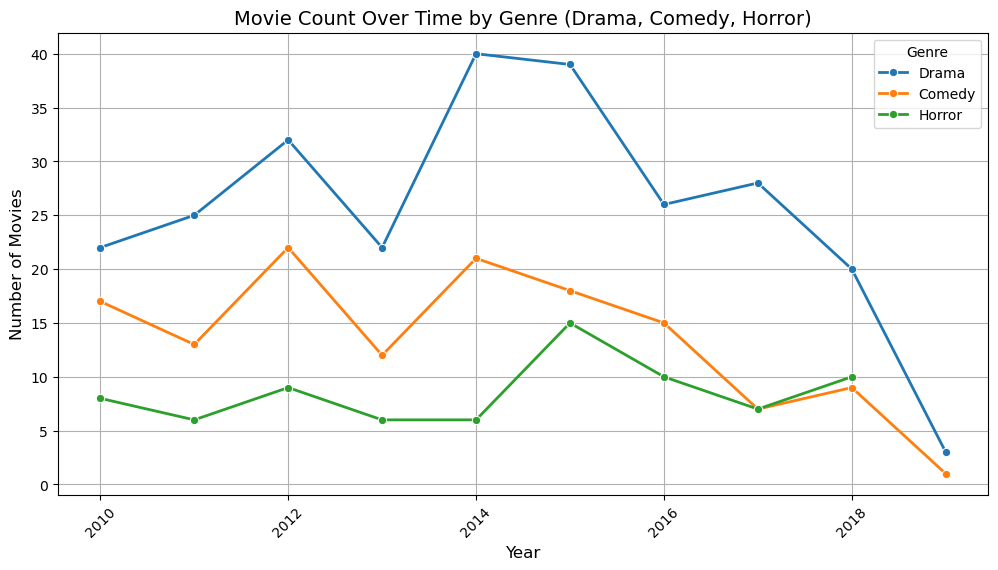

In [109]:
filtered_master_df['start_year'] = pd.to_numeric(filtered_master_df['start_year'], errors='coerce')

genre_trends = pd.DataFrame()
for genre in ['Drama', 'Comedy', 'Horror']:
    genre_counts = (
        filtered_master_df[filtered_master_df['genres'].str.contains(genre, case=False, na=False)]
        .groupby('start_year')
        .size()
        .reset_index(name=genre)
    )
    if genre_trends.empty:
        genre_trends = genre_counts
    else:
        genre_trends = genre_trends.merge(genre_counts, on='start_year', how='outer')

genre_trends = genre_trends.melt(id_vars=['start_year'], var_name='Genre', value_name='Movie Count')

plt.figure(figsize=(12,6))
sns.lineplot(x='start_year', y='Movie Count', hue='Genre', data=genre_trends, marker='o', linewidth=2)

plt.title('Movie Count Over Time by Genre (Drama, Comedy, Horror)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(True)
plt.legend(title="Genre")

plt.show()

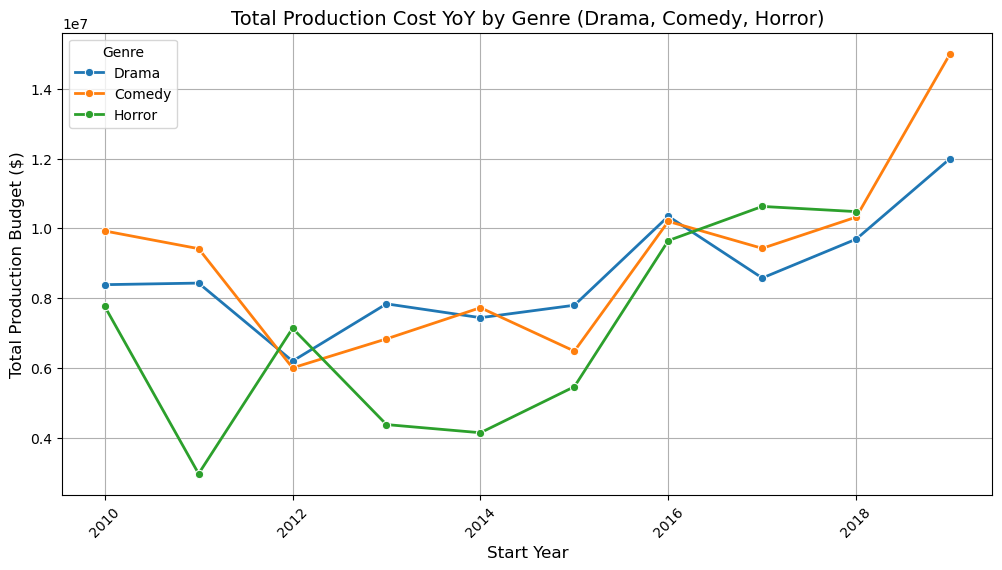

In [110]:
genre_budget_trends = pd.DataFrame()

for genre in ['Drama', 'Comedy', 'Horror']:
    genre_budget = (
        filtered_master_df[filtered_master_df['genres'].str.contains(genre, case=False, na=False)]
        .groupby('start_year')['production_budget']
        .mean()
        .reset_index(name=genre)
    )
    if genre_budget_trends.empty:
        genre_budget_trends = genre_budget
    else:
        genre_budget_trends = genre_budget_trends.merge(genre_budget, on='start_year', how='outer')

genre_budget_trends = genre_budget_trends.melt(id_vars=['start_year'], var_name='Genre', value_name='Total Budget')

plt.figure(figsize=(12,6))
sns.lineplot(x='start_year', y='Total Budget', hue='Genre', data=genre_budget_trends, marker='o', linewidth=2)

plt.title('Total Production Cost YoY by Genre (Drama, Comedy, Horror)', fontsize=14)
plt.xlabel('Start Year', fontsize=12)
plt.ylabel('Total Production Budget ($)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(True)
plt.legend(title="Genre")

plt.show()

In [111]:
print(genre_budget_trends.head(10))  # Show first 10 rows of the budget data

   start_year  Genre  Total Budget
0        2010  Drama  8.388636e+06
1        2011  Drama  8.433800e+06
2        2012  Drama  6.200625e+06
3        2013  Drama  7.839409e+06
4        2014  Drama  7.443625e+06
5        2015  Drama  7.800000e+06
6        2016  Drama  1.034615e+07
7        2017  Drama  8.579536e+06
8        2018  Drama  9.692500e+06
9        2019  Drama  1.200000e+07


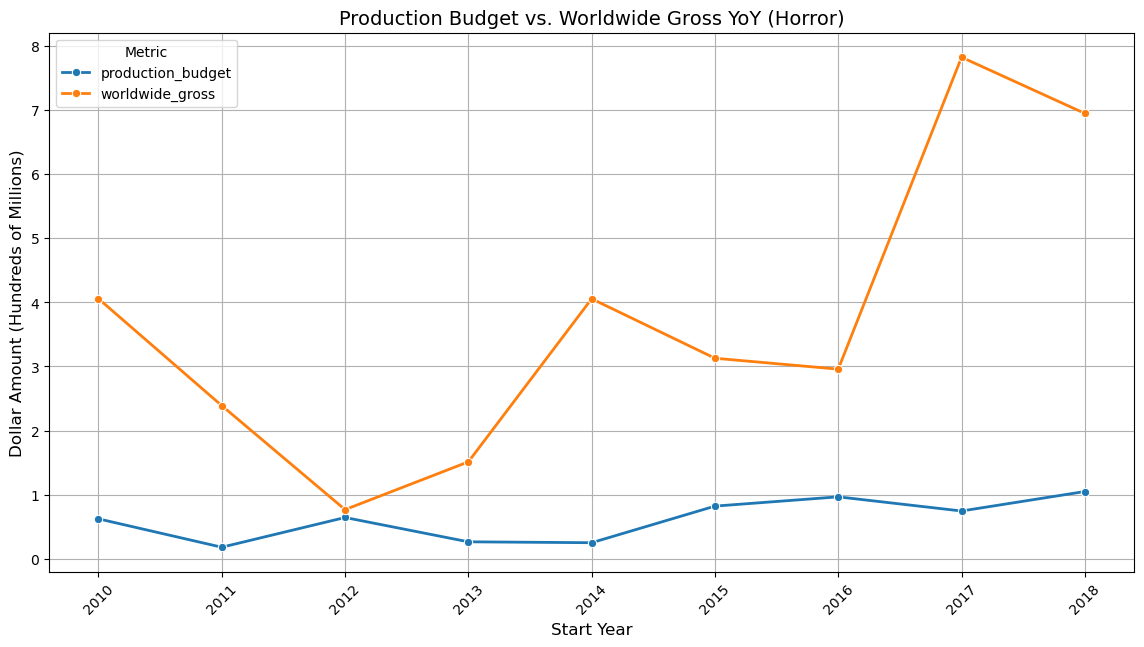

In [112]:
genre_financials = pd.DataFrame()

for genre in ['Horror']:
    genre_data = (
        filtered_master_df[filtered_master_df['genres'].str.contains(genre, case=False, na=False)]
        .groupby('start_year')[['production_budget', 'worldwide_gross']]
        .sum()
        .reset_index()
    )
    genre_data['Genre'] = genre
    genre_financials = pd.concat([genre_financials, genre_data], ignore_index=True)

genre_financials = genre_financials.melt(id_vars=['start_year', 'Genre'], 
                                         var_name='Metric', value_name='Amount')

genre_financials['Amount'] = genre_financials['Amount'] / 100_000_000

plt.figure(figsize=(14, 7))
sns.lineplot(x='start_year', y='Amount', hue='Metric', data=genre_financials, 
             marker='o', linewidth=2)

plt.title('Production Budget vs. Worldwide Gross YoY (Horror)', fontsize=14)
plt.xlabel('Start Year', fontsize=12)
plt.ylabel('Dollar Amount (Hundreds of Millions)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Metric")  # Ensure legend clearly differentiates Budget vs Gross

plt.show()

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_28950/3660383155.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='start_year', y='Amount', hue='Metric', data=genre_avg_financials,


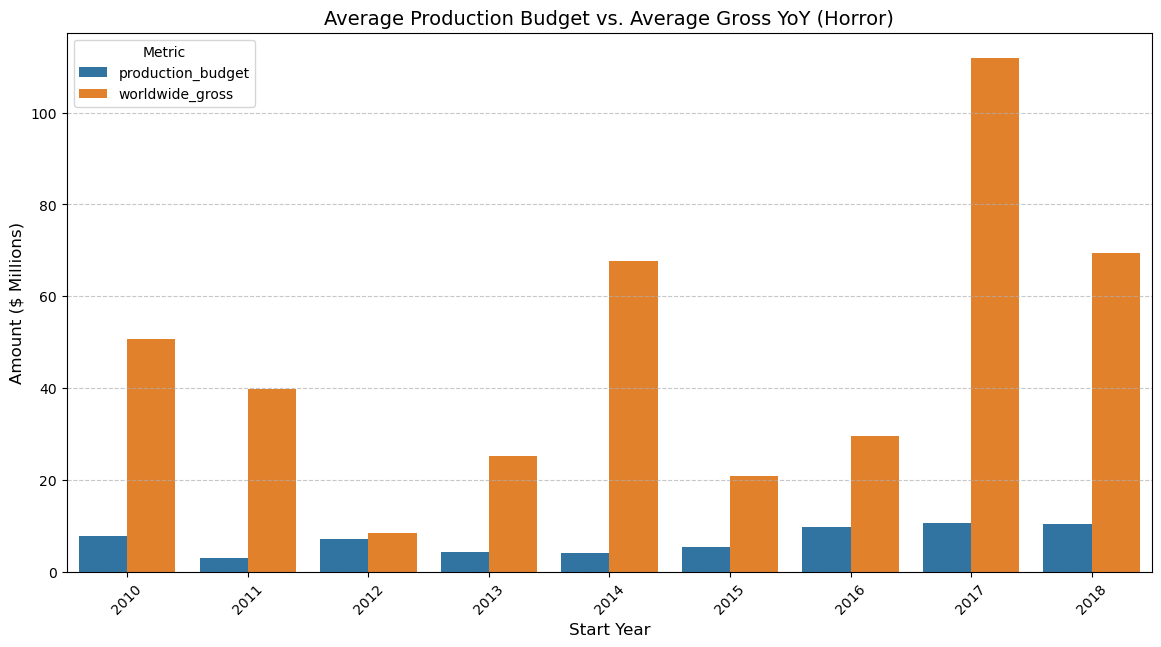

In [113]:
genre_avg_financials = pd.DataFrame()

for genre in ['Horror']:
    genre_data = (
        filtered_master_df[filtered_master_df['genres'].str.contains(genre, case=False, na=False)]
        .groupby('start_year')[['production_budget', 'worldwide_gross']]
        .mean()
        .reset_index()
    )
    genre_data['Genre'] = genre  # Add genre as a column
    genre_avg_financials = pd.concat([genre_avg_financials, genre_data], ignore_index=True)

genre_avg_financials = genre_avg_financials.melt(id_vars=['start_year', 'Genre'], 
                                                 var_name='Metric', value_name='Amount')

genre_avg_financials['Amount'] = genre_avg_financials['Amount'] / 1_000_000

plt.figure(figsize=(14, 7))
sns.barplot(x='start_year', y='Amount', hue='Metric', data=genre_avg_financials, 
            ci=None, palette=['#1f77b4', '#ff7f0e'])

plt.title('Average Production Budget vs. Average Gross YoY (Horror)', fontsize=14)
plt.xlabel('Start Year', fontsize=12)
plt.ylabel('Amount ($ Millions)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

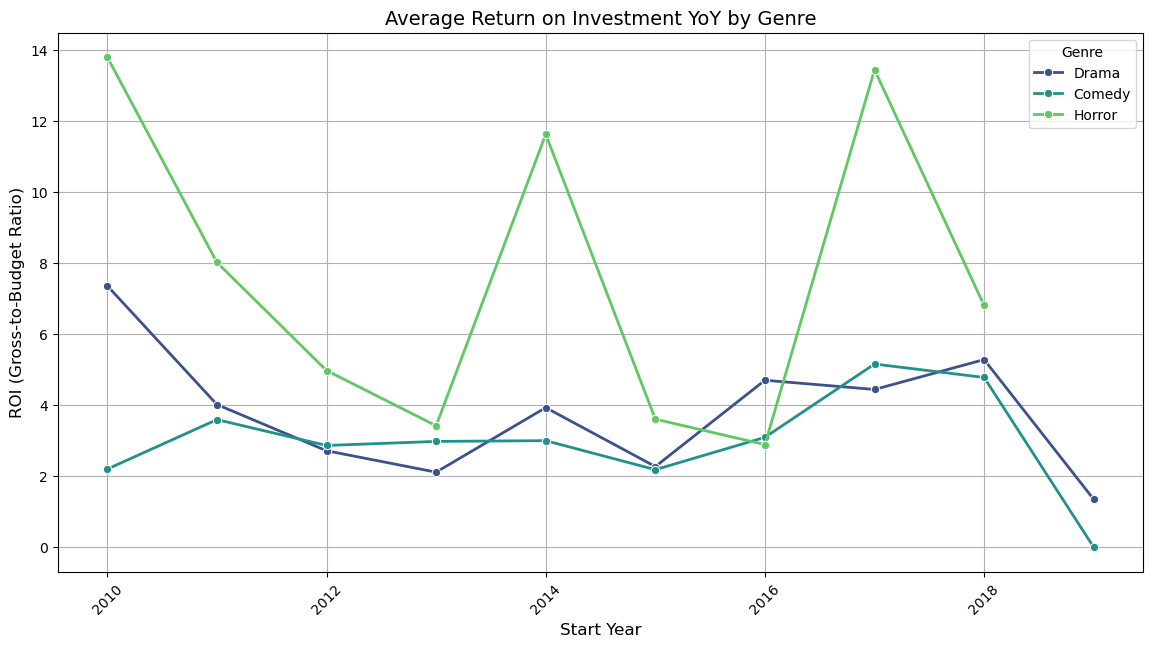

In [114]:
genre_roi_trends = pd.DataFrame()

for genre in ['Drama', 'Comedy', 'Horror']:
    genre_data = (
        filtered_master_df[filtered_master_df['genres'].str.contains(genre, case=False, na=False)]
        .groupby('start_year')['gross_budget_ratio']
        .mean()
        .reset_index()
    )
    genre_data['Genre'] = genre
    genre_roi_trends = pd.concat([genre_roi_trends, genre_data], ignore_index=True)

genre_roi_trends = genre_roi_trends.melt(id_vars=['start_year', 'Genre'], 
                                         var_name='Metric', value_name='ROI')

custom_palette = sns.color_palette("viridis", as_cmap=True)

plt.figure(figsize=(14, 7))
sns.lineplot(x='start_year', y='ROI', hue='Genre', data=genre_roi_trends, 
             marker='o', linewidth=2, palette="viridis")


plt.title('Average Return on Investment YoY by Genre', fontsize=14)
plt.xlabel('Start Year', fontsize=12)
plt.ylabel('ROI (Gross-to-Budget Ratio)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Genre")

plt.show()

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_28950/1934315329.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='start_year', y='gross_budget_ratio', data=horror_roi,


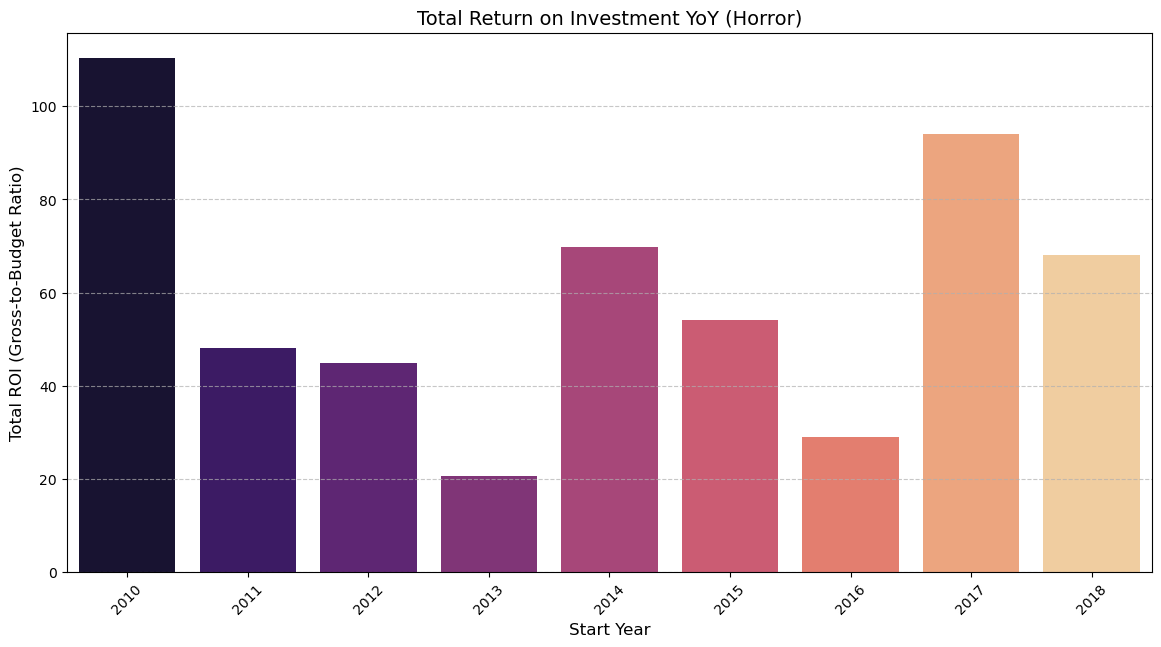

In [115]:
horror_roi = (
    filtered_master_df[filtered_master_df['genres'].str.contains('Horror', case=False, na=False)]
    .groupby('start_year')['gross_budget_ratio']
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 7))
sns.barplot(x='start_year', y='gross_budget_ratio', data=horror_roi, 
            palette="magma")  # Keep the same vibrant color scheme

plt.title('Total Return on Investment YoY (Horror)', fontsize=14)
plt.xlabel('Start Year', fontsize=12)
plt.ylabel('Total ROI (Gross-to-Budget Ratio)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [116]:
horror_df = filtered_master_df[filtered_master_df['genres'].str.contains('Horror', case=False, na=False)].groupby('start_year').agg({
    'production_budget': 'sum',
    'worldwide_gross': 'sum'
}).reset_index()

In [117]:
horror_averages = filtered_master_df[filtered_master_df['genres'].str.contains('Horror', case=False, na=False)].groupby('start_year').agg({
    'production_budget': 'mean',
    'worldwide_gross': 'mean' 
}).reset_index()
horror_averages

,start_year,production_budget,worldwide_gross
0,2010,7.768750e+06,5.072636e+07
1,2011,2.976667e+06,3.981214e+07
2,2012,7.140000e+06,8.505866e+06
3,2013,4.383333e+06,2.518934e+07
4,2014,4.150000e+06,6.761326e+07
5,2015,5.468333e+06,2.085679e+07
6,2016,9.650000e+06,2.958464e+07
7,2017,1.062857e+07,1.118224e+08
8,2018,1.048000e+07,6.950519e+07


In [118]:
# Rename the average columns before merging
horror_averages.columns = ['start_year', 'budget_avg', 'gross_avg']

# Merge them together
horror_df = horror_df.merge(horror_averages, on='start_year', how='left')

In [119]:
# Calculate ROI using the averages
horror_df['roi_avg'] = ((horror_df['gross_avg'] - horror_df['budget_avg']) / horror_df['budget_avg'] * 100).round(2)
horror_df['roi_avg'] = horror_df['roi_avg'].apply(lambda x: f"{x:.2f}%")

# Convert averages to integers
horror_df['budget_avg'] = horror_df['budget_avg'].astype(int)
horror_df['gross_avg'] = horror_df['gross_avg'].astype(int)

In [120]:
horror_df

,start_year,production_budget,worldwide_gross,budget_avg,gross_avg,roi_avg
0,2010,62150000,405810875,7768750,50726359,552.95%
1,2011,17860000,238872866,2976666,39812144,1237.47%
2,2012,64260000,76552792,7140000,8505865,19.13%
3,2013,26300000,151136063,4383333,25189343,474.66%
4,2014,24900000,405679580,4150000,67613263,1529.24%
5,2015,82025000,312851790,5468333,20856786,281.41%
6,2016,96500000,295846373,9650000,29584637,206.58%
7,2017,74400000,782757025,10628571,111822432,952.09%
8,2018,104800000,695051915,10480000,69505191,563.22%


In [121]:
horror_df['budget_gross_diff'] = horror_df['worldwide_gross'] - horror_df['production_budget']
horror_df

,start_year,production_budget,worldwide_gross,budget_avg,gross_avg,roi_avg,budget_gross_diff
0,2010,62150000,405810875,7768750,50726359,552.95%,343660875
1,2011,17860000,238872866,2976666,39812144,1237.47%,221012866
2,2012,64260000,76552792,7140000,8505865,19.13%,12292792
3,2013,26300000,151136063,4383333,25189343,474.66%,124836063
4,2014,24900000,405679580,4150000,67613263,1529.24%,380779580
5,2015,82025000,312851790,5468333,20856786,281.41%,230826790
6,2016,96500000,295846373,9650000,29584637,206.58%,199346373
7,2017,74400000,782757025,10628571,111822432,952.09%,708357025
8,2018,104800000,695051915,10480000,69505191,563.22%,590251915


In [122]:
horror_date_avg = horror_df[(horror_df['start_year'] >= 2014) & (horror_df['start_year'] <= 2018)]
horror_date_avg['difference'] = horror_date_avg['worldwide_gross'] - horror_date_avg['production_budget']
horror_date_diff = horror_date_avg['budget_gross_diff'].mean()
horror_date_diff

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_28950/3275901167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horror_date_avg['difference'] = horror_date_avg['worldwide_gross'] - horror_date_avg['production_budget']


np.float64(421912336.6)

In [123]:
drama_df = filtered_master_df[filtered_master_df['genres'].str.contains('Drama', case=False, na=False)].groupby('start_year')[['production_budget', 'worldwide_gross']].sum().reset_index()
drama_df

,start_year,production_budget,worldwide_gross
0,2010,184550000,1176684625
1,2011,210845000,644281899
2,2012,198420000,649151071
3,2013,172467000,479219171
4,2014,297745000,1043044453
5,2015,304200000,819679638
6,2016,269000000,1018989335
7,2017,240227000,969384371
8,2018,193850000,1038691887
9,2019,36000000,33469919


In [124]:
drama_averages = filtered_master_df[filtered_master_df['genres'].str.contains('Drama', case=False, na=False)].groupby('start_year').agg({
    'production_budget': 'mean',
    'worldwide_gross': 'mean'
}).reset_index()
drama_averages

,start_year,production_budget,worldwide_gross
0,2010,8.388636e+06,5.348566e+07
1,2011,8.433800e+06,2.577128e+07
2,2012,6.200625e+06,2.028597e+07
3,2013,7.839409e+06,2.178269e+07
4,2014,7.443625e+06,2.607611e+07
5,2015,7.800000e+06,2.101743e+07
6,2016,1.034615e+07,3.919190e+07
7,2017,8.579536e+06,3.462087e+07
8,2018,9.692500e+06,5.193459e+07
9,2019,1.200000e+07,1.115664e+07


In [125]:
# Rename the average columns before merging
drama_averages.columns = ['start_year', 'budget_avg', 'gross_avg']

# Merge them together
drama_df = drama_df.merge(drama_averages, on='start_year', how='left')

In [126]:
drama_df['roi_avg'] = ((drama_df['gross_avg'] - drama_df['budget_avg']) / drama_df['budget_avg'] * 100).round(2)
drama_df['roi_avg'] = drama_df['roi_avg'].apply(lambda x: f"{x:.2f}%")

# Convert averages to integers
drama_df['budget_avg'] = drama_df['budget_avg'].astype(int)
drama_df['gross_avg'] = drama_df['gross_avg'].astype(int)

In [127]:
comedy_df = filtered_master_df[filtered_master_df['genres'].str.contains('Comedy', case=False, na=False)].groupby('start_year')[['production_budget', 'worldwide_gross']].sum().reset_index()

In [128]:
comedy_averages = filtered_master_df[filtered_master_df['genres'].str.contains('Comedy', case=False, na=False)].groupby('start_year').agg({
    'production_budget': 'mean',
    'worldwide_gross': 'mean'
}).reset_index()

comedy_averages.columns = ['start_year', 'budget_avg', 'gross_avg']

# Merge them together
comedy_df = comedy_df.merge(comedy_averages, on='start_year', how='left')

In [129]:
# Calculate ROI using the averages
comedy_df['roi_avg'] = ((comedy_df['gross_avg'] - comedy_df['budget_avg']) / comedy_df['budget_avg'] * 100).round(2)
comedy_df['roi_avg'] = comedy_df['roi_avg'].apply(lambda x: f"{x:.2f}%")

# Convert averages to integers
comedy_df['budget_avg'] = comedy_df['budget_avg'].astype(int)
comedy_df['gross_avg'] = comedy_df['gross_avg'].astype(int)

comedy_df

,start_year,production_budget,worldwide_gross,budget_avg,gross_avg,roi_avg
0,2010,168750000,359556908,9926470,21150406,113.07%
1,2011,122450000,567936757,9419230,43687442,363.81%
2,2012,132140000,521325303,6006363,23696604,294.52%
3,2013,82045000,268471300,6837083,22372608,227.22%
4,2014,162320000,746892716,7729523,35566319,360.14%
5,2015,116750000,387414398,6486111,21523022,231.83%
6,2016,153000000,591081336,10200000,39405422,286.33%
7,2017,66000000,319612206,9428571,45658886,384.26%
8,2018,92900000,430728170,10322222,47858685,363.65%
9,2019,15000000,0,15000000,0,-100.00%


In [130]:
genre_fin = pd.concat([horror_df, comedy_df, drama_df], keys=['Horror', 'Comedy', 'Drama'], names=['genre']).reset_index(level=0)
genre_fin

,genre,start_year,production_budget,worldwide_gross,budget_avg,gross_avg,roi_avg,budget_gross_diff
0,Horror,2010,62150000,405810875,7768750,50726359,552.95%,343660875.0
1,Horror,2011,17860000,238872866,2976666,39812144,1237.47%,221012866.0
2,Horror,2012,64260000,76552792,7140000,8505865,19.13%,12292792.0
3,Horror,2013,26300000,151136063,4383333,25189343,474.66%,124836063.0
4,Horror,2014,24900000,405679580,4150000,67613263,1529.24%,380779580.0
5,Horror,2015,82025000,312851790,5468333,20856786,281.41%,230826790.0
6,Horror,2016,96500000,295846373,9650000,29584637,206.58%,199346373.0
7,Horror,2017,74400000,782757025,10628571,111822432,952.09%,708357025.0
8,Horror,2018,104800000,695051915,10480000,69505191,563.22%,590251915.0
0,Comedy,2010,168750000,359556908,9926470,21150406,113.07%,NaN


In [131]:
summary_df = (genre_fin[genre_fin['genre'].isin(['Comedy', 'Drama', 'Horror'])]
             .groupby('genre')
             .agg({
                 'budget_avg': 'mean',
                 'gross_avg': 'mean'
             })
             .round(2)
             .reset_index())

In [132]:
summary_df.columns = ['genre', 'budget_avg', 'gross_avg']

# Calculate ROI average
summary_df['roi_avg'] = ((summary_df['gross_avg'] - summary_df['budget_avg']) / summary_df['budget_avg'] * 100).round(2)

# Convert to millions
summary_df['budget_avg'] = summary_df['budget_avg'] / 1_000_000
summary_df['gross_avg'] = summary_df['gross_avg'] / 1_000_000

summary_df

,genre,budget_avg,gross_avg,roi_avg
0,Comedy,9.135557,30.091939,229.39
1,Drama,8.672428,30.532314,252.06
2,Horror,6.960628,47.068447,576.21


/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_28950/2835352755.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='genre', y='roi_avg', data=summary_df, palette='magma')


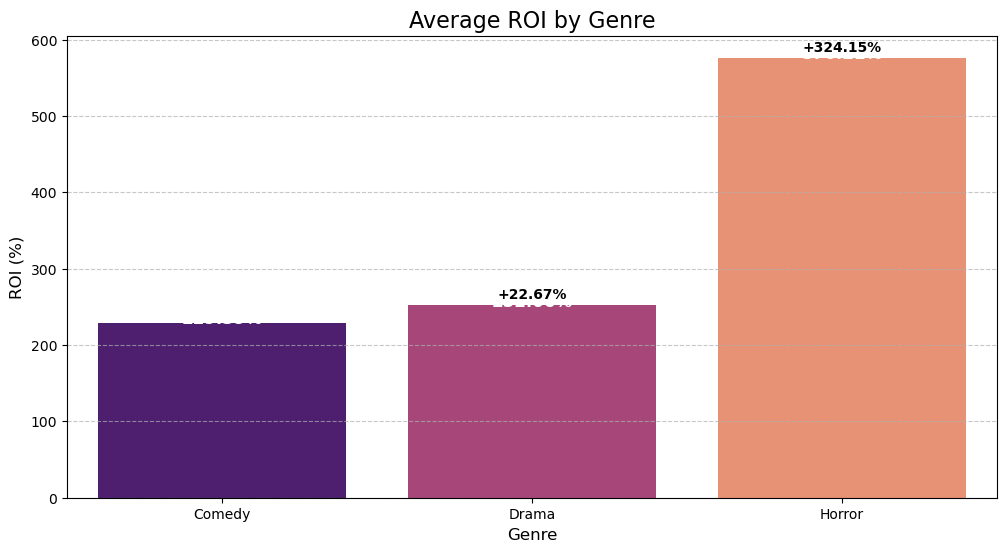

In [133]:
summary_df = summary_df.sort_values(by='roi_avg', ascending=True).reset_index(drop=True)

# Calculate the percentage difference
roi_diff = [0]  # First genre has no difference
for i in range(1, len(summary_df)):
    diff = summary_df.loc[i, 'roi_avg'] - summary_df.loc[i-1, 'roi_avg']
    roi_diff.append(diff)

# Plot the bar graph
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='genre', y='roi_avg', data=summary_df, palette='magma')

# Annotate each bar with ROI and differences
for i, bar in enumerate(barplot.patches):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 5, f'{summary_df.loc[i, "roi_avg"]:.2f}%', 
             ha='center', va='bottom', color='white', fontsize=12, weight='bold')
    
    if roi_diff[i] != 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'+{roi_diff[i]:.2f}%', 
                 ha='center', va='bottom', color='black', fontsize=10, weight='bold')

plt.title('Average ROI by Genre', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('ROI (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_28950/152683655.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=genre_fin, x='genre', y='budget_avg', linewidth=2, palette=box_colors)
/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_28950/152683655.py:14: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(data=genre_fin, x='genre', y='budget_avg', linewidth=2, palette=box_colors)


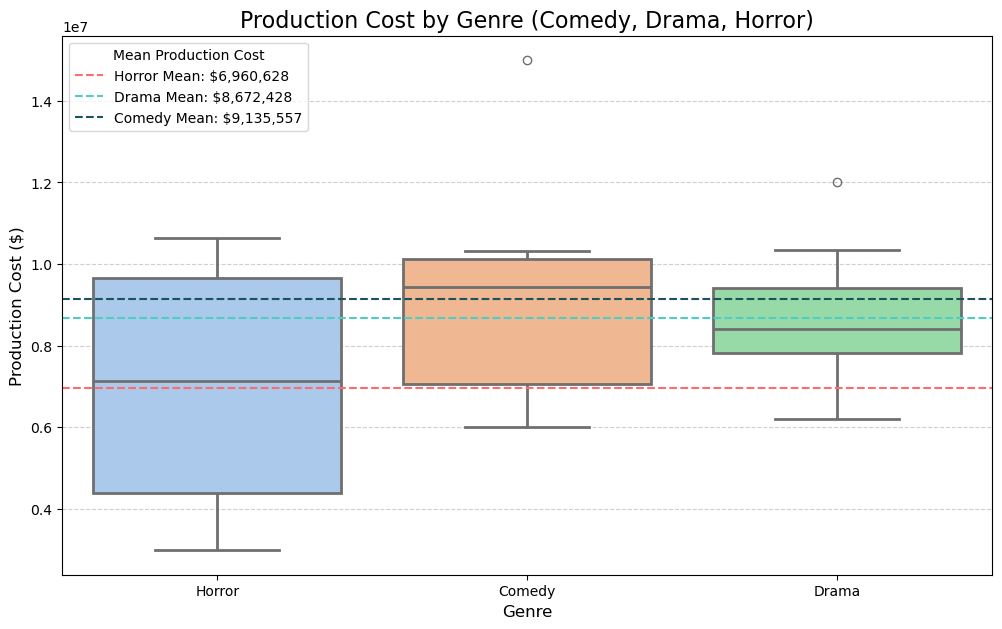

In [134]:
# Sort by budget_avg in ascending order
genre_fin = genre_fin.sort_values(by='budget_avg', ascending=True).reset_index(drop=True)

# Calculate the budget differences
budget_diff = [0]  # First genre has no difference
for i in range(1, len(genre_fin)):
    diff = genre_fin.loc[i, 'budget_avg'] - genre_fin.loc[i-1, 'budget_avg']
    budget_diff.append(diff)

# Choose a visually pleasing color palette for the box plots
box_colors = sns.color_palette("pastel")

plt.figure(figsize=(12, 7))
sns.boxplot(data=genre_fin, x='genre', y='budget_avg', linewidth=2, palette=box_colors)

# Define colors for each genre's mean line
mean_colors = ['#FF6B6B', '#4ECDC4', '#1A535C']

# Plot the mean lines with distinct colors
mean_values = genre_fin.groupby('genre')['budget_avg'].mean().sort_values()

for i, (genre, mean) in enumerate(mean_values.items()):
    plt.axhline(mean, linestyle='--', color=mean_colors[i], label=f'{genre} Mean: ${mean:,.0f}')

# Annotate the differences on the boxes
for i, box in enumerate(plt.gca().artists):
    height = mean_values.iloc[i]
    if budget_diff[i] != 0:
        plt.text(i, height + 2e5, f'+${budget_diff[i]:,.0f}', ha='center', va='bottom', fontsize=10, weight='bold')

plt.title('Production Cost by Genre (Comedy, Drama, Horror)', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Production Cost ($)', fontsize=12)
plt.legend(title="Mean Production Cost", loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

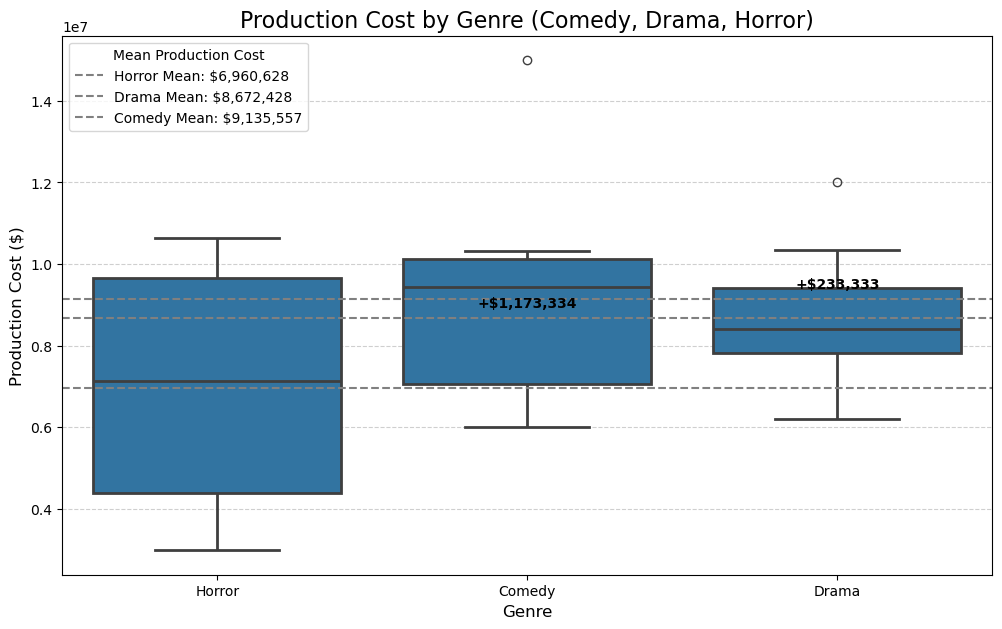

In [135]:
# Sort by budget_avg in ascending order
genre_fin = genre_fin.sort_values(by='budget_avg', ascending=True).reset_index(drop=True)

# Calculate the budget differences
budget_diff = [0]  # First genre has no difference
for i in range(1, len(genre_fin)):
    diff = genre_fin.loc[i, 'budget_avg'] - genre_fin.loc[i-1, 'budget_avg']
    budget_diff.append(diff)

plt.figure(figsize=(12, 7))
sns.boxplot(data=genre_fin, x='genre', y='budget_avg', linewidth=2)

# Plot the mean lines without annotations
mean_values = genre_fin.groupby('genre')['budget_avg'].mean().sort_values()

for genre, mean in mean_values.items():
    plt.axhline(mean, linestyle='--', label=f'{genre} Mean: ${mean:,.0f}', color='gray')

# Annotate only the differences
for i, bar in enumerate(plt.gca().containers[0]):
    if budget_diff[i] != 0:
        plt.text(i, mean_values.iloc[i] + 2e5, f'+${budget_diff[i]:,.0f}', ha='center', va='bottom', fontsize=10, weight='bold')

plt.title('Production Cost by Genre (Comedy, Drama, Horror)', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Production Cost ($)', fontsize=12)
plt.legend(title="Mean Production Cost", loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## Analysis 2: Director - Financial

Now that we've narrowed it down to the horror genre, let's take a look at the directors. In this section, we'll be focusing on the budgets, overall gross, and return on investment of each director in the category, so that we can make an informed business decision on who we should contract to make horror movies.

First, we'll look at the tn movie budgets data set to get a sense of the financials.

In [32]:
tn_movie_df.head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
6,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200"
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,"$300,000,000","$309,420,425","$963,420,425"
8,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209"
9,10,"Nov 6, 2015",Spectre,"$300,000,000","$200,074,175","$879,620,923"


Next, let's clean the data so that we can join it with data from the imdb dataset.

In [ ]:
def clean_data(tn_movie_df):
    # Derive column 'r_date' from column: 'release_date'
    def r_date(release_date):
        """
        Transform based on the following examples:
           release_date      Output
        1: "Dec 18, 2009" => "2009-12-18"
        """
        date1 = datetime.strptime(release_date, "%b %d, %Y")
        return date1.strftime("%Y-%m-%d")
    tn_movie_df.insert(2, "r_date", tn_movie_df.apply(lambda row : r_date(row["release_date"]), axis=1))
    # Drop column: 'release_date'
    tn_movie_df = tn_movie_df.drop(columns=['release_date'])
    # Sort by column: 'r_date' (ascending)
    tn_movie_df = tn_movie_df.sort_values(['r_date'])
    # Filter rows based on column: 'r_date' (movies after 2000)
    tn_movie_df = tn_movie_df[tn_movie_df['r_date'].str.startswith("2", na=False)]
    # Derive column 'p_budget' from column: 'production_budget'
    def p_budget(production_budget):
        """
        Transform based on the following examples:
           production_budget    Output
        1: "$9,500,000"      => "9500000"
        """
        number1 = float(production_budget.split("$")[-1].replace(",", ""))
        return f"{number1:01.0f}"
    tn_movie_df.insert(4, "p_budget", tn_movie_df.apply(lambda row : p_budget(row["production_budget"]), axis=1))
    # Derive column 'd_gross' from column: 'domestic_gross'
    def d_gross(domestic_gross):
        """
        Transform based on the following examples:
           domestic_gross    Output
        1: "$57,176,582"  => "57176582"
        """
        number1 = float(domestic_gross.split("$")[-1].replace(",", ""))
        return f"{number1:01.0f}"
    tn_movie_df.insert(6, "d_gross", tn_movie_df.apply(lambda row : d_gross(row["domestic_gross"]), axis=1))
    # Derive column 'w_gross' from column: 'worldwide_gross'
    def w_gross(worldwide_gross):
        """
        Transform based on the following examples:
           worldwide_gross    Output
        1: "$59,675,307"   => "59675307"
        """
        number1 = float(worldwide_gross.split("$")[-1].replace(",", ""))
        return f"{number1:01.0f}"
    tn_movie_df.insert(8, "w_gross", tn_movie_df.apply(lambda row : w_gross(row["worldwide_gross"]), axis=1))
    # Drop columns: 'production_budget', 'domestic_gross', 'worldwide_gross'
    tn_movie_df = tn_movie_df.drop(columns=['production_budget', 'domestic_gross', 'worldwide_gross'])
    # Change column type to int64 for columns: 'p_budget', 'd_gross', 'w_gross'
    tn_movie_df = tn_movie_df.astype({'p_budget': 'int64', 'd_gross': 'int64', 'w_gross': 'int64'})
    # Created column 'gross_budget_ratio' (ROI Multiplier) by dividing the worldwide gross by the production budget
    tn_movie_df['gross_budget_ratio'] = tn_movie_df['w_gross'] / tn_movie_df['p_budget']
    # Sort by column: 'gross_budget_ratio' (descending)
    tn_movie_df = tn_movie_df.sort_values(['gross_budget_ratio'], ascending=[False])
    # Drop column: 'd_gross'
    tn_movie_df = tn_movie_df.drop(columns=['d_gross'])
    # Change column type to datetime64[ns] for column: 'r_date'
    tn_movie_df = tn_movie_df.astype({'r_date': 'datetime64[ns]'})
    # Derive column 'r_year' from column: 'r_date'
    # Transform based on the following examples:
    #    r_date        Output
    # 1: 2009-09-25 => "2009"
    tn_movie_df.insert(2, "r_year", tn_movie_df.apply(lambda row : row["r_date"].strftime("%Y"), axis=1))
    return tn_movie_df

tn_movie_df_clean = clean_data(tn_movie_df.copy())
tn_movie_df_clean.head(10)

,id,r_date,r_year,movie,p_budget,w_gross,gross_budget_ratio
5492,93,2009-09-25,2009,Paranormal Activity,450000,194183034,431.517853
5679,80,2015-07-10,2015,The Gallows,100000,41656474,416.564740
5709,10,2004-05-07,2004,Super Size Me,65000,22233808,342.058585
5781,82,2005-08-05,2005,My Date With Drew,1100,181041,164.582727
5656,57,2007-05-16,2007,Once,150000,23323631,155.490873
5774,75,2004-10-08,2004,Primer,7000,841926,120.275143
5507,8,2004-06-11,2004,Napoleon Dynamite,400000,46122713,115.306782
5430,31,2004-08-06,2004,Open Water,500000,55518641,111.037282
5680,81,2006-09-29,2006,Facing the Giants,100000,10243159,102.431590
5211,12,2012-01-06,2012,The Devil Inside,1000000,101759490,101.759490


Since we have set our studio's budget at $20M, let's look at all of the movies in the dataset that have a budget less than or equal to that amount

In [34]:
tn_movie_df_clean = tn_movie_df_clean[(tn_movie_df_clean['p_budget'] <= 20000000)]
tn_movie_df_clean

,id,r_date,r_year,movie,p_budget,w_gross,gross_budget_ratio
5492,93,2009-09-25,2009,Paranormal Activity,450000,194183034,431.517853
5679,80,2015-07-10,2015,The Gallows,100000,41656474,416.564740
5709,10,2004-05-07,2004,Super Size Me,65000,22233808,342.058585
5781,82,2005-08-05,2005,My Date With Drew,1100,181041,164.582727
5656,57,2007-05-16,2007,Once,150000,23323631,155.490873
...,...,...,...,...,...,...,...
5419,20,2015-02-24,2015,Irreplaceable,600000,0,0.000000
5600,1,2015-02-24,2015,Give Me Shelter,250000,0,0.000000
4640,41,2015-03-03,2015,To Write Love On Her Arms,3400000,0,0.000000
5332,33,2015-03-03,2015,Ask Me Anything,950000,0,0.000000


Now, we'll combine the movie title and the year into a single string and set the index of the df as that column so that it will be easier to perform a join with a different df later on.

In [35]:
tn_movie_df_clean['movie_title'] = tn_movie_df_clean['movie'] + " (" + tn_movie_df_clean['r_year'] + ")"
tn_movie_df_clean = tn_movie_df_clean.set_index('movie_title')
tn_movie_df_clean

,id,r_date,r_year,movie,p_budget,w_gross,gross_budget_ratio
movie_title,,,,,,,
Paranormal Activity (2009),93,2009-09-25,2009,Paranormal Activity,450000,194183034,431.517853
The Gallows (2015),80,2015-07-10,2015,The Gallows,100000,41656474,416.564740
Super Size Me (2004),10,2004-05-07,2004,Super Size Me,65000,22233808,342.058585
My Date With Drew (2005),82,2005-08-05,2005,My Date With Drew,1100,181041,164.582727
Once (2007),57,2007-05-16,2007,Once,150000,23323631,155.490873
...,...,...,...,...,...,...,...
Irreplaceable (2015),20,2015-02-24,2015,Irreplaceable,600000,0,0.000000
Give Me Shelter (2015),1,2015-02-24,2015,Give Me Shelter,250000,0,0.000000
To Write Love On Her Arms (2015),41,2015-03-03,2015,To Write Love On Her Arms,3400000,0,0.000000


Now that we have a df with the budget and gross info for movies, let's take a look at the imdb dataset to find the movie details and directors.

In [36]:
query = """
select movie_id, primary_title, primary_name, start_year, genres
from movie_akas 
join movie_basics using(movie_id)
join directors using(movie_id)
join persons using(person_id)
where (region = 'US') and (start_year >= 2000)
group by movie_id
"""
movie_director_df = pd.read_sql(query, conn)
movie_director_df = movie_director_df.rename(columns={'primary_title': 'movie', 'primary_name' : 'director'})
movie_director_df['movie_title'] = movie_director_df['movie'] + " (" + movie_director_df['start_year'].astype(str) + ")"
movie_director_df = movie_director_df.set_index('movie_title')
movie_director_df

,movie_id,movie,director,start_year,genres
movie_title,,,,,
The Other Side of the Wind (2018),tt0069049,The Other Side of the Wind,Orson Welles,2018,Drama
Bigfoot (2017),tt0112502,Bigfoot,Mc Jones,2017,"Horror,Thriller"
Cooper and Hemingway: The True Gen (2013),tt0159369,Cooper and Hemingway: The True Gen,John Mulholland,2013,Documentary
Heaven & Hell (2018),tt0192528,Heaven & Hell,Stuart Paul,2018,Drama
The Final Journey (2010),tt0230212,The Final Journey,R.J. Adams,2010,Drama
...,...,...,...,...,...
Monkey King Reloaded (2017),tt9837530,Monkey King Reloaded,Paul Wang,2017,Adventure
End of the Century (2019),tt9845398,End of the Century,Lucio Castro,2019,Drama
The House Elf (2019),tt9875852,The House Elf,Evgeniy Bedarev,2019,"Comedy,Family,Fantasy"


Now, let's join the budgets and movie details tables based on the combo name/year field we made earlier.

In [37]:
comb_df = tn_movie_df_clean.join(movie_director_df, on='movie_title', how='inner', rsuffix='_md')
smaller_df = comb_df[['movie_id','start_year', 'p_budget', 'w_gross', 'gross_budget_ratio', 'director', 'genres']]
smaller_df

,movie_id,start_year,p_budget,w_gross,gross_budget_ratio,director,genres
movie_title,,,,,,,
The Gallows (2015),tt2309260,2015,100000,41656474,416.564740,Chris Lofing,"Horror,Mystery,Thriller"
The Devil Inside (2012),tt1560985,2012,1000000,101759490,101.759490,William Brent Bell,Horror
Paranormal Activity 2 (2010),tt1536044,2010,3000000,177512032,59.170677,Tod Williams,Horror
Get Out (2017),tt5052448,2017,5000000,255367951,51.073590,Jordan Peele,"Horror,Mystery,Thriller"
Moonlight (2016),tt4975722,2016,1500000,65245512,43.497008,Barry Jenkins,Drama
...,...,...,...,...,...,...,...
Into the Grizzly Maze (2015),tt1694021,2015,10000000,0,0.000000,David Hackl,"Action,Adventure,Drama"
Subconscious (2015),tt2909932,2015,500000,0,0.000000,Georgia Hilton,"Action,Mystery,Thriller"
Daisy Winters (2017),tt3702088,2017,4500000,0,0.000000,Beth LaMure,Drama


I made this helper function to determine the count for each genre in the df.

In [38]:
def genre_count(input_df):
    output_dict = {}
    for index, row in input_df.iterrows():
        genre_list = row['genres'].split(',')
        for genre in genre_list:
            if genre in output_dict:
                output_dict[genre] += 1
            else:
                output_dict[genre] = 1
    return output_dict

test_dict = genre_count(smaller_df)
test_dict

{'Horror': 122,
 'Mystery': 72,
 'Thriller': 122,
 'Drama': 348,
 'Action': 78,
 'Biography': 53,
 'Documentary': 33,
 'Fantasy': 31,
 'Romance': 101,
 'Comedy': 193,
 'Music': 30,
 'Sci-Fi': 34,
 'Crime': 72,
 'Family': 26,
 'Adventure': 34,
 'Sport': 16,
 'History': 9,
 'Animation': 8,
 'War': 9,
 'Western': 4,
 'Musical': 2}

Now that we have our combined dataframe, we can look at only movies in the horror genre.

In [39]:
horror_df = smaller_df[smaller_df['genres'].str.contains("Horror")]
horror_df

,movie_id,start_year,p_budget,w_gross,gross_budget_ratio,director,genres
movie_title,,,,,,,
The Gallows (2015),tt2309260,2015,100000,41656474,416.564740,Chris Lofing,"Horror,Mystery,Thriller"
The Devil Inside (2012),tt1560985,2012,1000000,101759490,101.759490,William Brent Bell,Horror
Paranormal Activity 2 (2010),tt1536044,2010,3000000,177512032,59.170677,Tod Williams,Horror
Get Out (2017),tt5052448,2017,5000000,255367951,51.073590,Jordan Peele,"Horror,Mystery,Thriller"
Chernobyl Diaries (2012),tt1991245,2012,1000000,42411721,42.411721,Bradley Parker,"Horror,Mystery,Thriller"
...,...,...,...,...,...,...,...
Wind Walkers (2015),tt1236254,2015,2000000,0,0.000000,Russell Friedenberg,"Action,Horror,Thriller"
House at the End of the Drive (2014),tt0464054,2014,1400000,0,0.000000,David Worth,"Horror,Thriller"
The Walking Deceased (2015),tt3499458,2015,2000000,0,0.000000,Scott Dow,"Comedy,Horror"


Now, we wanna group based on director to try to determine which one would have the most financial success.

In [40]:
horror_df.groupby(['director'])['gross_budget_ratio'].agg('mean').sort_values(ascending=False).head(10)

director
Chris Lofing          416.564740
Tod Williams           59.170677
William Brent Bell     54.290793
Bradley Parker         42.411721
Henry Joost            34.985784
Jordan Peele           31.892053
Scott Derrickson       29.242602
Jeff Wadlow            27.179241
David Gordon Green     25.490067
David F. Sandberg      25.060147
Name: gross_budget_ratio, dtype: float64

As you can see, the director with the highest ROI is significantly higher than the rest of the data, which will skew any analytics that we do on this dataset. In order to prevent this bias, we decided to only look at directors that had directed more than 1 horror film.

In [41]:
director_counts = horror_df['director'].value_counts()
director_counts = director_counts[director_counts > 1]
dc_list = director_counts.index.to_list()
dc_list

['Christopher Landon',
 'James DeMonaco',
 'Mike Flanagan',
 'John Erick Dowdle',
 'Jordan Peele',
 'Gregory Plotkin',
 'Henry Joost',
 'John R. Leonetti',
 'Daniel Stamm',
 'David F. Sandberg',
 'Deon Taylor',
 'Ciarán Foy',
 'William Brent Bell',
 'Kevin Smith']

Now that we have our short list of 14 horror movie directors, let's refilter our df to show only movies from those directors.

In [42]:
filtered_by_directors_df = horror_df[horror_df['director'].isin(dc_list)]
filtered_by_directors_df = filtered_by_directors_df[filtered_by_directors_df['gross_budget_ratio'] > 0]

director_mean_roi = filtered_by_directors_df.groupby(['director'])['gross_budget_ratio'].agg('mean').sort_values(ascending=False)
director_mean_roi


director
William Brent Bell    54.290793
Henry Joost           34.985784
Jordan Peele          31.892053
David F. Sandberg     25.060147
John R. Leonetti      20.736909
Daniel Stamm          19.496472
James DeMonaco        18.222144
Christopher Landon    12.837767
John Erick Dowdle      7.350112
Deon Taylor            7.304296
Gregory Plotkin        5.545172
Ciarán Foy             5.410423
Mike Flanagan          4.607322
Kevin Smith            0.562542
Name: gross_budget_ratio, dtype: float64

Now, we can see that the three directors with the highest average return on investment are William Brent Bell, Henry Joost, and Jordan Peele. Let's look more in depth at the stats for each director.

In [43]:
director_stats_df = filtered_by_directors_df.groupby(['director'])['w_gross'].agg(['sum', 'max', 'count']).sort_values(by='sum', ascending=False)
director_stats_df = director_stats_df.join(director_mean_roi, on='director')
director_stats_df = director_stats_df.rename(columns={'sum': 'total_gross', 'max': 'highest_gross', 'count': 'num_movies', 'gross_budget_ratio': 'average_roi'})
director_stats_df

,total_gross,highest_gross,num_movies,average_roi
director,,,,
Jordan Peele,509578261,255367951,2,31.892053
David F. Sandberg,454191375,305384865,2,25.060147
Henry Joost,349857836,207039844,2,34.985784
James DeMonaco,321316189,118514727,3,18.222144
Christopher Landon,295649464,125010260,4,12.837767
John R. Leonetti,280340265,256862920,2,20.736909
William Brent Bell,169980442,101759490,2,54.290793
John Erick Dowdle,105178180,63354114,2,7.350112
Gregory Plotkin,96078605,77959374,2,5.545172


Based on the production budget column, I made a new column that shows the average budget for each director.

In [44]:
directors_average_budget = filtered_by_directors_df.groupby(['director'])['p_budget'].agg('mean')
director_stats_df = director_stats_df.join(directors_average_budget, on='director')
# Rename column 'p_budget' to 'average_budget'
director_stats_df = director_stats_df.rename(columns={'p_budget': 'average_budget'})
    # Round columns 'average_roi', 'average_budget' (Number of decimals: 2)
director_stats_df = director_stats_df.round({'average_roi': 2, 'average_budget': 2})
director_stats_df

,total_gross,highest_gross,num_movies,average_roi,average_budget
director,,,,,
Jordan Peele,509578261,255367951,2,31.89,12500000.00
David F. Sandberg,454191375,305384865,2,25.06,10000000.00
Henry Joost,349857836,207039844,2,34.99,5000000.00
James DeMonaco,321316189,118514727,3,18.22,7333333.33
Christopher Landon,295649464,125010260,4,12.84,8500000.00
John R. Leonetti,280340265,256862920,2,20.74,9250000.00
William Brent Bell,169980442,101759490,2,54.29,5500000.00
John Erick Dowdle,105178180,63354114,2,7.35,7500000.00
Gregory Plotkin,96078605,77959374,2,5.55,7750000.00


Finally, I exported the dataframes to csvs in order to work with them in Tableau.

In [45]:
filtered_by_directors_df.reset_index().to_csv('./zippedData/horror_movies_by_director.csv')
director_stats_df.reset_index().to_csv('./zippedData/horror_director_stats.csv')

### Visualization
![director tableau](./images/Screenshot%202025-02-12%20at%203.20.48 PM.png)

In Tableau, I made a side by side bar graph comparing the average ROI and average production budgets for our short list of 14 directors. This is sorted by average ROI in descending order.

## Analysis 3: Director - Ratings

Movies after year 2000 director names

In [47]:
query = """
select movie_id, primary_title, primary_name, start_year, genres
from movie_akas 
join movie_basics using(movie_id)
join directors using(movie_id)
join persons using(person_id)
where (region = 'US') and (start_year >= 2000)
group by movie_id
"""

movie_director_df = pd.read_sql(query, conn)
movie_director_df = movie_director_df.rename(columns={'primary_title': 'movie', 'primary_name' : 'director'})
movie_director_df['movie_title'] = movie_director_df['movie'] + " (" + movie_director_df['start_year'].astype(str) + ")"
movie_director_df

,movie_id,movie,director,start_year,genres,movie_title
0,tt0069049,The Other Side of the Wind,Orson Welles,2018,Drama,The Other Side of the Wind (2018)
1,tt0112502,Bigfoot,Mc Jones,2017,"Horror,Thriller",Bigfoot (2017)
2,tt0159369,Cooper and Hemingway: The True Gen,John Mulholland,2013,Documentary,Cooper and Hemingway: The True Gen (2013)
3,tt0192528,Heaven & Hell,Stuart Paul,2018,Drama,Heaven & Hell (2018)
4,tt0230212,The Final Journey,R.J. Adams,2010,Drama,The Final Journey (2010)
...,...,...,...,...,...,...
46236,tt9837530,Monkey King Reloaded,Paul Wang,2017,Adventure,Monkey King Reloaded (2017)
46237,tt9845398,End of the Century,Lucio Castro,2019,Drama,End of the Century (2019)
46238,tt9875852,The House Elf,Evgeniy Bedarev,2019,"Comedy,Family,Fantasy",The House Elf (2019)
46239,tt9882084,Chasing Happiness,John Taylor,2019,Documentary,Chasing Happiness (2019)


Filtering out the works of the selected directors

In [48]:
directors = [
    'Christopher Landon', 'James DeMonaco', 'Mike Flanagan', 'John Erick Dowdle',
    'Jordan Peele', 'Gregory Plotkin', 'Henry Joost', 'John R. Leonetti',
    'Daniel Stamm', 'David F. Sandberg', 'Deon Taylor', 'Ciarán Foy',
    'William Brent Bell', 'Kevin Smith'
]

filtered_df = movie_director_df[movie_director_df['director'].isin(directors)]
filtered_df

,movie_id,movie,director,start_year,genres,movie_title
71,tt0448115,Shazam!,David F. Sandberg,2019,"Action,Adventure,Comedy",Shazam! (2019)
284,tt0873886,Red State,Kevin Smith,2011,"Action,Crime,Horror",Red State (2011)
732,tt1152278,NY Export: Opus Jazz,Henry Joost,2010,"Drama,Musical",NY Export: Opus Jazz (2010)
1203,tt1283887,Burning Palms,Christopher Landon,2010,"Comedy,Thriller",Burning Palms (2010)
1369,tt1314655,Devil,John Erick Dowdle,2010,"Horror,Mystery,Thriller",Devil (2010)
1397,tt1320244,The Last Exorcism,Daniel Stamm,2010,"Drama,Horror,Thriller",The Last Exorcism (2010)
1781,tt1385867,Cop Out,Kevin Smith,2010,"Action,Comedy,Crime",Cop Out (2010)
3183,tt1560985,The Devil Inside,William Brent Bell,2012,Horror,The Devil Inside (2012)
3452,tt1584016,Catfish,Henry Joost,2010,"Documentary,Drama,Mystery",Catfish (2010)
3797,tt1610996,Absentia,Mike Flanagan,2011,"Drama,Horror,Mystery",Absentia (2011)


In [49]:
ratings_query = """
select movie_id, averagerating
from movie_ratings
join movie_basics using(movie_id)
join movie_akas using(movie_id)
where (region = 'US') and (start_year >= 2000)
group by movie_id
"""
ratings_df = pd.read_sql(ratings_query, conn)
ratings_df

,movie_id,averagerating
0,tt0069049,6.9
1,tt0112502,4.1
2,tt0159369,7.6
3,tt0192528,4.0
4,tt0230212,8.8
...,...,...
26649,tt9815714,4.7
26650,tt9822474,7.7
26651,tt9845398,7.2
26652,tt9875852,5.8


Concatenating the 2 dfs and adding reviews

In [50]:
merged_df = filtered_df.join(ratings_df.set_index('movie_id'), on='movie_id', how='left')
merged_df = merged_df.dropna()
merged_df = merged_df[merged_df["start_year"]>2000]
merged_df

,movie_id,movie,director,start_year,genres,movie_title,averagerating
71,tt0448115,Shazam!,David F. Sandberg,2019,"Action,Adventure,Comedy",Shazam! (2019),7.4
284,tt0873886,Red State,Kevin Smith,2011,"Action,Crime,Horror",Red State (2011),6.2
732,tt1152278,NY Export: Opus Jazz,Henry Joost,2010,"Drama,Musical",NY Export: Opus Jazz (2010),7.5
1203,tt1283887,Burning Palms,Christopher Landon,2010,"Comedy,Thriller",Burning Palms (2010),5.4
1369,tt1314655,Devil,John Erick Dowdle,2010,"Horror,Mystery,Thriller",Devil (2010),6.2
1397,tt1320244,The Last Exorcism,Daniel Stamm,2010,"Drama,Horror,Thriller",The Last Exorcism (2010),5.6
1781,tt1385867,Cop Out,Kevin Smith,2010,"Action,Comedy,Crime",Cop Out (2010),5.6
3183,tt1560985,The Devil Inside,William Brent Bell,2012,Horror,The Devil Inside (2012),4.2
3452,tt1584016,Catfish,Henry Joost,2010,"Documentary,Drama,Mystery",Catfish (2010),7.1
3797,tt1610996,Absentia,Mike Flanagan,2011,"Drama,Horror,Mystery",Absentia (2011),5.8


**Filtering rows based on Horror genres**

In [51]:
# Filter rows where the 'genres' column contains 'Horror'
merged_df = merged_df[merged_df["genres"].str.contains("Horror", case=False, na=False)]
merged_df

,movie_id,movie,director,start_year,genres,movie_title,averagerating
284,tt0873886,Red State,Kevin Smith,2011,"Action,Crime,Horror",Red State (2011),6.2
1369,tt1314655,Devil,John Erick Dowdle,2010,"Horror,Mystery,Thriller",Devil (2010),6.2
1397,tt1320244,The Last Exorcism,Daniel Stamm,2010,"Drama,Horror,Thriller",The Last Exorcism (2010),5.6
3183,tt1560985,The Devil Inside,William Brent Bell,2012,Horror,The Devil Inside (2012),4.2
3797,tt1610996,Absentia,Mike Flanagan,2011,"Drama,Horror,Mystery",Absentia (2011),5.8
5646,tt1727776,Scouts Guide to the Zombie Apocalypse,Christopher Landon,2015,"Action,Comedy,Horror",Scouts Guide to the Zombie Apocalypse (2015),6.3
6622,tt1778304,Paranormal Activity 3,Henry Joost,2011,"Horror,Mystery,Thriller",Paranormal Activity 3 (2011),5.8
9783,tt1999890,Hell Fest,Gregory Plotkin,2018,Horror,Hell Fest (2018),5.5
10510,tt2059171,13 Sins,Daniel Stamm,2014,"Horror,Thriller",13 Sins (2014),6.3
11426,tt2109184,Paranormal Activity 4,Henry Joost,2012,"Horror,Mystery,Thriller",Paranormal Activity 4 (2012),4.6


Visualizing the rating and sorting

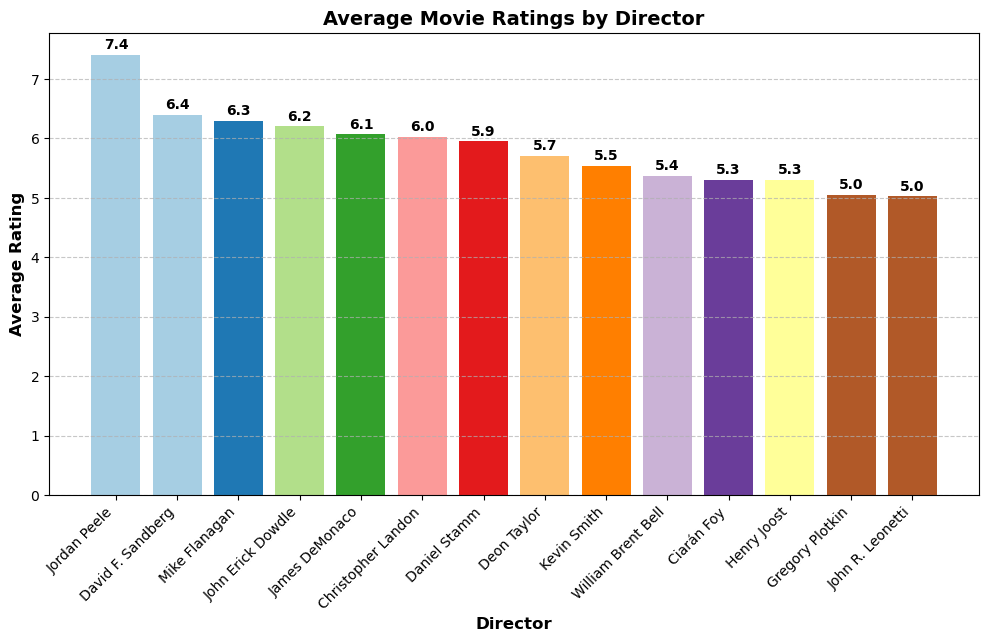

In [52]:
#Visualizing by Average ratings and director based on horror movies
director_avg_ratings = merged_df.groupby("director")["averagerating"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
colors = plt.cm.Paired(np.linspace(0, 1, len(director_avg_ratings)))  # Generate colors
bars = plt.bar(director_avg_ratings.index, director_avg_ratings.values, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 1), ha='center', fontsize=10, fontweight='bold', color='black')

plt.xlabel("Director", fontsize=12, fontweight='bold')
plt.ylabel("Average Rating", fontsize=12, fontweight='bold')
plt.title("Average Movie Ratings by Director", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a light grid for better readability
plt.show()

**All works of Selected top three director based on their movie ratings**

In [53]:
#Selecting top three director based on their movie ratings
directors = [
    'William Brent Bell',
    'Henry Joost',
    'Jordan Peele'
]

filtered_df = merged_df[merged_df['director'].isin(directors)]
filtered_df

,movie_id,movie,director,start_year,genres,movie_title,averagerating
3183,tt1560985,The Devil Inside,William Brent Bell,2012,Horror,The Devil Inside (2012),4.2
6622,tt1778304,Paranormal Activity 3,Henry Joost,2011,"Horror,Mystery,Thriller",Paranormal Activity 3 (2011),5.8
11426,tt2109184,Paranormal Activity 4,Henry Joost,2012,"Horror,Mystery,Thriller",Paranormal Activity 4 (2012),4.6
12993,tt2229511,Wer,William Brent Bell,2013,"Action,Horror,Mystery",Wer (2013),5.9
17652,tt2597892,Viral,Henry Joost,2016,"Drama,Horror,Sci-Fi",Viral (2016),5.5
27207,tt3882082,The Boy,William Brent Bell,2016,"Horror,Mystery,Thriller",The Boy (2016),6.0
33802,tt5052448,Get Out,Jordan Peele,2017,"Horror,Mystery,Thriller",Get Out (2017),7.7
42616,tt6857112,Us,Jordan Peele,2019,"Horror,Mystery,Thriller",Us (2019),7.1


**Create bar plots for each director separately**

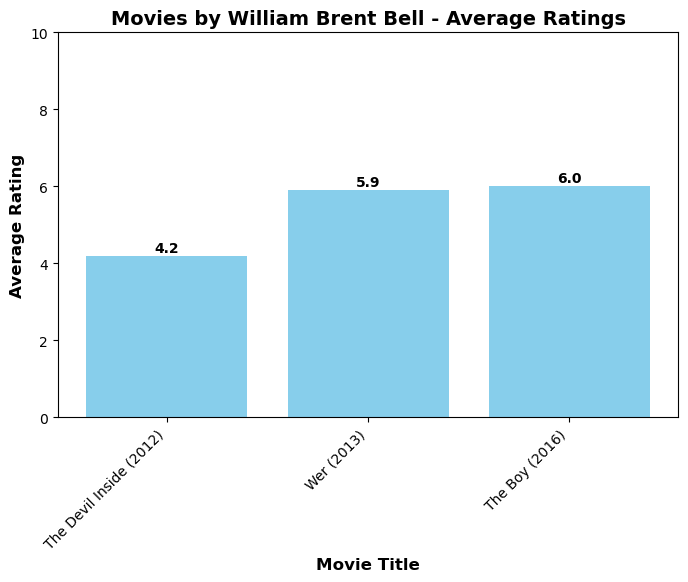

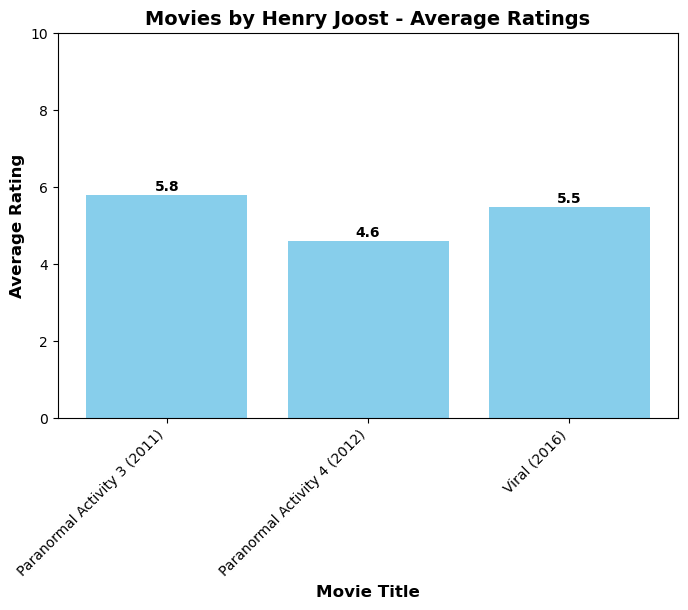

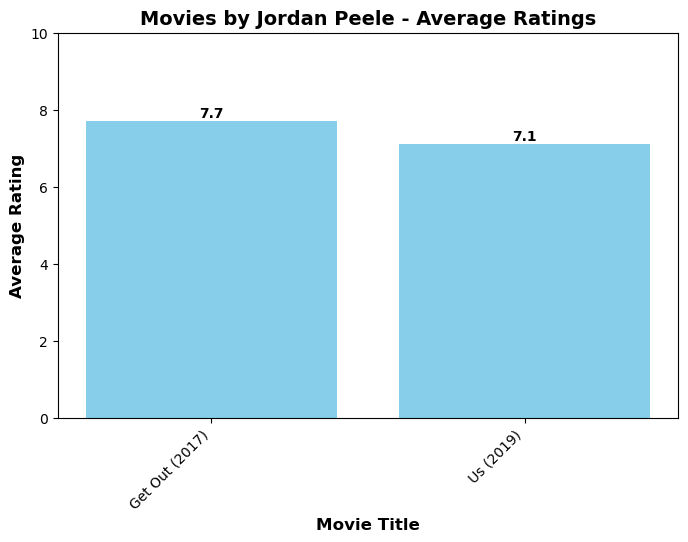

In [54]:
# Create bar plots for each director separately
for director in ['William Brent Bell', 'Henry Joost', 'Jordan Peele']:
    director_df = filtered_df[filtered_df['director'] == director]
    
    plt.figure(figsize=(8, 5))
    plt.bar(director_df['movie_title'], director_df['averagerating'], color='skyblue')
    plt.xlabel("Movie Title", fontsize=12, fontweight='bold')
    plt.ylabel("Average Rating", fontsize=12, fontweight='bold')
    plt.title(f"Movies by {director} - Average Ratings", fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.ylim(0, 10)  # Ratings are usually between 0-10

    # Adding value labels on top of bars
    for i, v in enumerate(director_df['averagerating']):
        plt.text(i, v + 0.1, str(v), ha='center', fontsize=10, fontweight='bold')

    plt.show()

## Conclusion

Our business recommendation is to use the $20 million to make **two horror movies**: one directed by *Jordan Peele*, and the other by *Henry Joost*. These two directors have the right combination of ROI and critical acclaim to guarantee success for our new studio!